In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.0 MB/s eta 0:00:00


In [2]:
# =================================
# LIBRARIES
# =================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
# =================================
# LOAD & PREVIEW DATA
# =================================

# Create a directory for the data
!mkdir -p data

# Download the dataset from data.transportation.gov
!wget -O data/raw_data.csv "https://data.transportation.gov/api/views/9ivb-8ae9/rows.csv?accessType=DOWNLOAD"
# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Set a style for the plots
sns.set(style="whitegrid")

# Load the Dataset
data_path = "data/raw_data.csv"
df_full = pd.read_csv(data_path)

# Display the first few rows of the dataframe
df_full.head()

#print(df.columns)


--2025-03-20 19:50:57--  https://data.transportation.gov/api/views/9ivb-8ae9/rows.csv?accessType=DOWNLOAD
Resolving data.transportation.gov (data.transportation.gov)... 52.206.68.26, 52.206.140.205, 52.206.140.199
Connecting to data.transportation.gov (data.transportation.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data/raw_data.csv’

data/raw_data.csv       [                 <=>]  91.30M  4.89MB/s    in 18s     

2025-03-20 19:51:16 (5.10 MB/s) - ‘data/raw_data.csv’ saved [95738829]



,NTD ID,Agency,Primary UZA UACE Code,Rail/Bus/Ferry,Mode Name,Mode,TOS,Fixed Route Flag,Year,Event Description,...,Occupant of Other Vehicle Injuries,Occupant of Other Vehicle Serious Injuries,Other Injuries,Other Serious Injuries,Suicide Injuries,Suicide Serious Injuries,Trespasser Inuries (Subtotal),Trespasser Serious Injuries (Subtotal),Total Serious Injuries,Person List
0,20080,New Jersey Transit Corporation,63217,Bus,Bus,MB,DO,True,2024,Bus was parked in <REDACTED> <REDACTED> and an...,...,0,0,0,0,0,0,0,0,0,NaN
1,40035,Central Florida Regional Transportation Authority,65863,Bus,Demand Response,DR,DO,False,2024,Another vehicle made other front contact with ...,...,1,0,0,0,0,0,0,0,0,I Operator Inside Adult (19 to 60) F ; I ...
2,50027,Metro Transit,57628,Rail,Light Rail,LR,DO,True,2024,Officers responded to a shooting . Suspect was...,...,0,0,0,0,0,0,0,0,0,F Passenger Adult (19 to 60) M
3,90026,San Diego Metropolitan Transit System,78661,Rail,Light Rail,LR,DO,True,2024,San Diego Police took a female into custody af...,...,0,0,0,0,0,0,0,0,0,I Wait Leave Adult (19 to 60) M Y
4,20080,New Jersey Transit Corporation,63217,Bus,Bus,MB,DO,True,2024,operator was driving down <REDACTED> <REDACTED...,...,1,0,0,0,0,0,0,0,0,I Occ Other Veh Adult (19 to 60) M


In [4]:

# =================================
# CLEANING & FEATURE ENGINEERING
# =================================
#df['Year'] = df['Event Date'].dt.year
#df['Month'] = df['Event Date'].dt.month
#df['Weekday'] = df['Event Date'].dt.weekday

# Selected Columns
# Define the list of columns to keep
columns_to_keep = [
    'NTD ID',
    'Primary UZA UACE Code',
    'Rail/Bus/Ferry',
    'Mode Name',
    'Mode',
    'TOS',
    'Fixed Route Flag',
    'Year',
    'Event Date',
    'Event Time',
    'Event Type',
    'Event Type Group',
    'Collision With',
    'Property Damage',
    'Total Injuries',
    'Total Fatalities',
    'Towed (Y/N)',
    'Number of Transit Vehicles Involved',
    'Number of Non-Transit Vehicles Involved',
    'Number of Cars on Involved Transit Vehicles',
    'Non-Transit Vehicle Type List',
    'Location Type',
    'Latitude',
    'Longitude',
    'Weather',
    'Lighting',
    'Road Configuration',
    'Path Condition',
    'Right of Way Condition',
    'Intersection Control Device',
    'Transit Vehicle Action',
    'Other Transit Vehicle Action Description',
    'Non-Transit Vehicle Action List',
    'Transit (Y/N)',
    'Fuel Type',
    'Vehicle Speed',
    'Transit Vehicle Type',
    'Non-Transit Vehicle Type',
    'Transit Vehicle Manufacturer',
    'Total Serious Injuries'
]

df = df_full[columns_to_keep]
df.columns = df.columns.str.replace(' ', '')
print(df.dtypes)

NTDID                                      int64
PrimaryUZAUACECode                         int64
Rail/Bus/Ferry                            object
ModeName                                  object
Mode                                      object
TOS                                       object
FixedRouteFlag                              bool
Year                                       int64
EventDate                                 object
EventTime                                 object
EventType                                 object
EventTypeGroup                            object
CollisionWith                             object
PropertyDamage                           float64
TotalInjuries                              int64
TotalFatalities                            int64
Towed(Y/N)                                object
NumberofTransitVehiclesInvolved            int64
NumberofNon-TransitVehiclesInvolved        int64
NumberofCarsonInvolvedTransitVehicles      int64
Non-TransitVehicleTy

In [52]:
# Create a directory for the data
!mkdir -p data

# Download urban list record from https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/2010-urban-lists-record-layout.html
!wget -O data/census_data_2010.csv "https://raw.githubusercontent.com/cody-plans/transit-safety-insights/feature_engineering/data/census_data_2010.csv"
#https://github.com/cody-plans/transit-safety-insights/blob/feature_engineering/data/census_data_2010.csv
#!head -n 10 data/census_data_2010.csv

import os
print("File exists:", os.path.exists(data_path1))
print("File size:", os.path.getsize(data_path1), "bytes")

data_path1 = "data/census_data_2010.csv"

import csv
#df_census_data = pd.read_csv(data_path1, on_bad_lines="skip")
df_census_data = pd.read_csv(data_path1)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Set a style for the plots
sns.set(style="whitegrid")

# Load the Dataset

#df_census_data = pd.read_csv(data_path1)

# Display the first few rows of the dataframe
df_census_data.head()



--2025-03-20 22:39:33--  https://raw.githubusercontent.com/cody-plans/transit-safety-insights/feature_engineering/data/census_data_2010.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241914 (236K) [text/plain]
Saving to: ‘data/census_data_2010.csv’

data/census_data_20 100%[===================>] 236.24K  --.-KB/s    in 0.02s   

2025-03-20 22:39:33 (11.3 MB/s) - ‘data/census_data_2010.csv’ saved [241914/241914]

File exists: True
File size: 241914 bytes


,UACE,NAME,POP,HU,AREALAND,AREALANDSQMI,AREAWATER,AREAWATERSQMI,POPDEN,LSADC
0,37,"Abbeville, LA",19824,8460,29222871,11.28,300497,0.12,1757.0,76
1,64,"Abbeville, SC",5243,2578,11315197,4.37,19786,0.01,1200.1,76
2,91,"Abbotsford, WI",3966,1616,5363441,2.07,13221,0.01,1915.2,76
3,118,"Aberdeen, MS",4666,2050,7416616,2.86,52732,0.02,1629.4,76
4,145,"Aberdeen, SD",25977,12114,33002447,12.74,247597,0.10,2038.6,76


In [53]:
# add one feature Density in df_census_data
# Arealand: unit meters square
# Density = POP/(AREALAND/1000)
df_census_data['Density'] = df_census_data['POP']/df_census_data['AREALAND']*1000

# normalize the columns
df_census_data['Density'] = (df_census_data['Density'] - df_census_data['Density'].min()) / (df_census_data['Density'].max() - df_census_data['Density'].min())

#select uace and density and show head
df_census_data[['UACE', 'Density']].head()

,UACE,Density
0,37,0.144370
1,64,0.086678
2,91,0.160758
3,118,0.131157
4,145,0.173549


In [55]:
# join df with df_census_data
# join on df[Primary UZA UACE Code] = df_census_data[UACE]
# left join df on df_census_data
# select only Density from df_census_data and keep all columns in df


# Assuming df and df_census_data are already defined DataFrames

# Select only the 'UACE' and 'Density' columns from df_census_data
df_census_data_subset = df_census_data[['UACE', 'Density']]

# Perform a left merge on the key: df["Primary UZA UACE Code"] = df_census_data["UACE"]
df = pd.merge(df, df_census_data_subset, left_on='PrimaryUZAUACECode', right_on='UACE', how='left')

# df now contains all columns from df and the 'Density' column from df_census_data
print(df.head())

   NTDID  PrimaryUZAUACECode Rail/Bus/Ferry         ModeName Mode TOS  Year  \
0  20080               63217            Bus              Bus   MB  DO  2024   
1  40035               65863            Bus  Demand Response   DR  DO  2024   
2  20080               63217            Bus              Bus   MB  DO  2024   
3  30006               74746            Bus              Bus   MB  DO  2024   
4      1               80389            Bus              Bus   MB  DO  2024   

   EventDate EventTime           EventType  ... Month Day    Weekday  \
0 2024-11-30  08:46:00  Non-Rail Collision  ...    11  30   Saturday   
1 2024-11-30  19:09:00  Non-Rail Collision  ...    11  30   Saturday   
2 2024-11-27  15:20:00  Non-Rail Collision  ...    11  27  Wednesday   
3 2024-11-25  07:38:00  Non-Rail Collision  ...    11  25     Monday   
4 2024-11-23  18:08:00  Non-Rail Collision  ...    11  23   Saturday   

       Season  Hour  TimeOfDay  RushHour  MajorSafety     UACE   Density  
0  non-winter    

In [57]:
eventtype = 'Non-Rail Collision'

df = df.query('EventType == @eventtype')

# Convert columns to datetime objects
df['EventDate'] = pd.to_datetime(df['EventDate'], format='%Y %B %d')
df['EventTime'] = pd.to_datetime(df['EventTime'].astype(str)).dt.time


# Extract features from Event Date
df['Month'] = df['EventDate'].dt.month
df['Day'] = df['EventDate'].dt.day
df['Weekday'] = df['EventDate'].dt.day_name()

# Create season feature (winter vs non-winter)
df['Season'] = df['Month'].apply(lambda m: 'winter' if m in [12, 1, 2] else 'non-winter')

# Convert Event Time to extract the hour (assuming it's in 24-hour format)
# Since 'Event Time' is already datetime.time, you can extract hour directly:
df['Hour'] = df['EventTime'].apply(lambda t: t.hour) #Using apply to access the hour attribute

# Categorize time of day
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['TimeOfDay'] = df['Hour'].apply(categorize_time)

# Create rush hour flag
def is_rush_hour(hour):
    return 1 if (7 <= hour < 10 or 16 <= hour < 19) else 0

df['RushHour'] = df['Hour'].apply(is_rush_hour) #Removed extra =

# Select columns to display for checking
columns = ['EventDate', 'EventTime', 'Hour', 'TimeOfDay', 'RushHour', 'Season', 'Weekday', 'Day', 'Month']
print(df[columns].head())

# Store the new dataset to a new CSV file
#df = pd.read_csv('../data/feature_engineered_data.csv', index=False)

df['Towed(Y/N)'] = df['Towed(Y/N)'].map({'Y': True, 'N': False})

#df['FixedRouteFlag'] = df['FixedRouteFlag'].map({'true': True, 'false': False})

print(df.dtypes)
df.columns = df.columns.str.replace(' ', '')


   EventDate EventTime  Hour  TimeOfDay  RushHour      Season    Weekday  Day  \
0 2024-11-30  08:46:00     8    morning         1  non-winter   Saturday   30   
1 2024-11-30  19:09:00    19    evening         0  non-winter   Saturday   30   
2 2024-11-27  15:20:00    15  afternoon         0  non-winter  Wednesday   27   
3 2024-11-25  07:38:00     7    morning         1  non-winter     Monday   25   
4 2024-11-23  18:08:00    18    evening         1  non-winter   Saturday   23   

   Month  
0     11  
1     11  
2     11  
3     11  
4     11  
NTDID                                          category
PrimaryUZAUACECode                                int64
Rail/Bus/Ferry                                 category
ModeName                                       category
Mode                                           category
TOS                                            category
Year                                           category
EventDate                                datetime64[ns]

In [64]:
# count the number of missing values in each column
print(df.dtypes)
missing_values = df.isnull().sum()

# drop columns with more than 10% missing values
columns_to_drop = missing_values[missing_values > 0.1 * df.shape[0]].index
print(columns_to_drop)
df = df.drop(columns=columns_to_drop)

# drop rows with missing values
df = df.dropna()  #drop missing values first before dropping columns?


# drop duplicates
df = df.drop_duplicates()

# save the cleaned data, save to data folder as data_cleaned.csv
df.to_csv('data/cleaned_data.csv', index=False)

# print the number of rows and columns in the cleaned data
print(df.shape)

# print the number of missing values in the cleaned data
print(df.isnull().sum())

# print the number of duplicates in the cleaned data
print(df.duplicated().sum())

nominal_cols = ['UACE', 'Rail/Bus/Ferry', 'ModeName', 'Mode', 'TOS', 'Weather', 'Lighting', 'RoadConfiguration', 'PathCondition', 'RightofWayCondition', 'FuelType', 'TransitVehicleType', 'TransitVehicleManufacturer', 'NTDID', 'PrimaryUZAUACECode', 'Year', 'Month', 'Day']  # Update with actual nominal variables
df[nominal_cols] = df[nominal_cols].astype('category')

print(df.dtypes)

# print the first few rows of the cleaned data
print(df.head())

NTDID                                          category
PrimaryUZAUACECode                             category
Rail/Bus/Ferry                                 category
ModeName                                       category
Mode                                           category
TOS                                            category
Year                                           category
EventDate                                datetime64[ns]
EventTime                                        object
EventType                                        object
EventTypeGroup                                   object
CollisionWith                                    object
PropertyDamage                                  float64
TotalInjuries                                     int64
TotalFatalities                                   int64
NumberofTransitVehiclesInvolved                   int64
NumberofNon-TransitVehiclesInvolved               int64
NumberofCarsonInvolvedTransitVehicles           

In [65]:
# =================================
# DEFINE TARGET VARIABLE
# =================================
df['MajorSafety'] = (
    (df['TotalFatalities'] > 0) |
    (df['TotalSeriousInjuries'] >0) |
    (df['TotalInjuries'] >0) |
    (df['PropertyDamage'] >25000)

).astype(int)

X = df.drop(columns=['MajorSafety', 'TotalFatalities','TotalSeriousInjuries','TotalInjuries', 'PropertyDamage', 'Hour', 'EventDate', 'EventTime'])
y = df['MajorSafety']

#f['Is_Severe'].value_counts()


In [66]:
# =================================
# PREPROCESSING PIPELINE
# =================================
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64', 'float64','bool']).columns

#preprocessor = ColumnTransformer([
#    ('num', StandardScaler(), num_cols),
#    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
#])


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', TargetEncoder(handle_unknown='ignore'), cat_cols)  # Replace OHE with TargetEncoder
])

In [67]:
baseline_classifier = RandomForestClassifier(n_estimators=200, max_depth = 15, random_state=42)
classifier1= GradientBoostingClassifier()
classifier2= BaggingClassifier(DecisionTreeClassifier(max_features = 1, max_depth = 7), n_estimators=150, max_samples=0.5)
classifier3= ExtraTreesClassifier(n_estimators=100, random_state=42)
classifier10 = KNeighborsClassifier(n_neighbors=5)


#classifier__bootstrap': True, 'classifier__estimator__max_depth': 7, 'classifier__max_features': 1.0, 'classifier__max_samples': 0.5, 'classifier__n_estimators': 150}

#Best parameters: {'classifier__max_depth': 15, 'classifier__n_estimators': 200}
#Best score: 0.7921443300178334

In [68]:
Pipeline_Base = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', baseline_classifier)
])


Pipeline_1 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier1)
])

Pipeline_2 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier2)
])

Pipeline_3 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier3)
])

#BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
#KNeighborsClassifier()


In [69]:
# =================================
# MODEL TRAINING
# =================================
#pipeline = Pipeline([
#    ('preprocessing', preprocessor),
#    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
#])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [5, 10, 15, 20]
}

# Perform GridSearchCV
grid_search = GridSearchCV(Pipeline_Base, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Best parameters: {'classifier__max_depth': 15, 'classifier__n_estimators': 200}
Best score: 0.7921443300178334


In [70]:
Pipeline_Base.fit(X_train, y_train)
y_pred = Pipeline_Base.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.04      0.08      2785
           1       0.78      0.99      0.87      9500

    accuracy                           0.78     12285
   macro avg       0.67      0.52      0.47     12285
weighted avg       0.73      0.78      0.69     12285

Confusion Matrix:
[[ 114 2671]
 [  87 9413]]
ROC-AUC Score: 0.5158878389870547



Top 10 Predictive Features:
                                       Feature  Importance
5                                 num__Density    0.266233
3                            num__VehicleSpeed    0.115925
11   cat__OtherTransitVehicleActionDescription    0.083011
13                                cat__Weekday    0.081663
8                           cat__CollisionWith    0.079858
2   num__NumberofCarsonInvolvedTransitVehicles    0.074108
10                   cat__TransitVehicleAction    0.065945
12                           cat__Transit(Y/N)    0.052013
9                            cat__LocationType    0.050983
15                              cat__TimeOfDay    0.050410


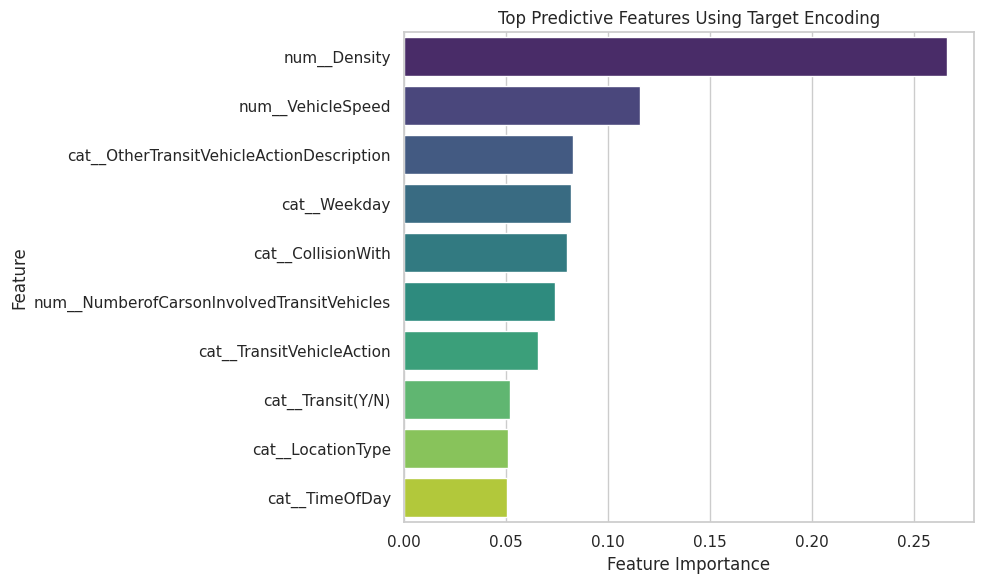

In [71]:
# Access trained classifier
rf_model = Pipeline_Base.named_steps['classifier']

# Get feature names
all_feature_names = Pipeline_Base.named_steps['preprocessing'].get_feature_names_out()

# Get feature importances
importances = rf_model.feature_importances_

# Create DataFrame for visualization
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictive Features Using Target Encoding")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Top 10 Predictive Features:
                                      Feature  Importance  \
3                             num__Towed(Y/N)    0.204898   
13                             cat__EventTime    0.131560   
0                                  num__NTDID    0.080748   
1                     num__PrimaryUZAUACECode    0.062395   
2                                   num__Year    0.058439   
7                           num__VehicleSpeed    0.047413   
29                               cat__Weekday    0.044104   
28            cat__TransitVehicleManufacturer    0.040159   
24  cat__OtherTransitVehicleActionDescription    0.034126   
31                             cat__TimeOfDay    0.026399   

                             Original Feature  
3                             num__Towed(Y/N)  
13                             cat__EventTime  
0                                  num__NTDID  
1                     num__PrimaryUZAUACECode  
2                                   num__Year  
7          

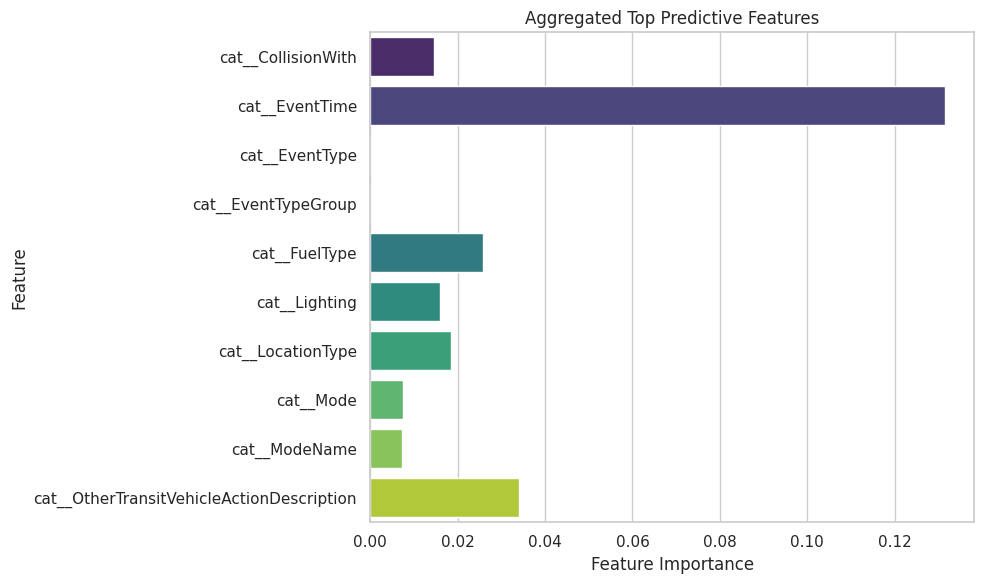

In [ ]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_Base.named_steps['classifier']

# Get feature names
ohe = Pipeline_Base.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
#all_feature_names = list(num_cols) + list(encoded_cat_cols)
all_feature_names = Pipeline_Base.named_steps['preprocessing'].get_feature_names_out()

# Get importances
importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


# Mapping only for categorical features
#original_feature_map = {encoded: original.split('_')[0] for encoded, original in zip(encoded_cat_cols, cat_cols)}
original_feature_map = {encoded: encoded.split('_')[0] for encoded in encoded_cat_cols}

# Aggregate importance by original feature
#feat_importance_df['Original Feature'] = feat_importance_df['Feature'].apply(
#    lambda x: original_feature_map[x] if x in original_feature_map else x
#)

feat_importance_df['Original Feature'] = feat_importance_df['Feature'].apply(
    lambda x: original_feature_map[x] if x in encoded_cat_cols else x
)

top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

aggregated_importance = feat_importance_df.groupby('Original Feature')['Importance'].sum().reset_index()
# Plot the aggregated feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Original Feature', data=aggregated_importance.head(top_n), palette='viridis')
plt.title("Aggregated Top Predictive Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Display top N features

#print(f"\nTop {top_n} Predictive Features:")
#print(feat_importance_df.head(top_n))

# Plot top features
#plt.figure(figsize=(10, 6))
#sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
#plt.title("Top Predictors of Major Safety Incidents")
#plt.xlabel("Feature Importance")
#plt.ylabel("Feature")
#plt.tight_layout()
#plt.show()


In [ ]:
Pipeline_1.fit(X_train, y_train)
y_pred = Pipeline_1.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_1.named_steps['classifier']

# Get feature names
all_feature_names = Pipeline_1.named_steps['preprocessing'].get_feature_names_out()

# Get feature importances
importances = rf_model.feature_importances_

# Create DataFrame for visualization
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictive Features Using Target Encoding")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

AttributeError: 'HistGradientBoostingClassifier' object has no attribute 'feature_importances_'

In [17]:
# Define parameter grid
param_grid_bagging = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_samples': [0.5, 0.75, 1.0],
    'classifier__max_features': [0.5, 0.75, 1.0],
    'classifier__bootstrap': [True, False],
   'classifier__estimator__max_depth': [3, 5, 7]  # Base DecisionTreeClassifier parameters
}

# GridSearchCV
grid_search_bagging = GridSearchCV(
    estimator=Pipeline_2, param_grid=param_grid_bagging, cv=5, n_jobs=-1, verbose=2, scoring='accuracy'
)

# Fit GridSearchCV
grid_search_bagging.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters for BaggingClassifier:", grid_search_bagging.best_params_)

# Best model
best_bagging_model = grid_search_bagging.best_estimator_



Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters for BaggingClassifier: {'classifier__bootstrap': True, 'classifier__estimator__max_depth': 7, 'classifier__max_features': 1.0, 'classifier__max_samples': 0.5, 'classifier__n_estimators': 150}


In [28]:
Pipeline_2.fit(X_train, y_train)
y_pred = Pipeline_2.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2834
           1       0.77      1.00      0.87      9597

    accuracy                           0.77     12431
   macro avg       0.39      0.50      0.44     12431
weighted avg       0.60      0.77      0.67     12431

Confusion Matrix:
[[   0 2834]
 [   0 9597]]
ROC-AUC Score: 0.5



Top 10 Predictive Features:
                                       Feature  Importance  \
0                              num__Towed(Y/N)    0.634297   
8                           cat__CollisionWith    0.087733   
3   num__NumberofCarsonInvolvedTransitVehicles    0.056333   
11   cat__OtherTransitVehicleActionDescription    0.042545   
12                           cat__Transit(Y/N)    0.040996   
2     num__NumberofNon-TransitVehiclesInvolved    0.037617   
10                   cat__TransitVehicleAction    0.034158   
4                            num__VehicleSpeed    0.026905   
9                            cat__LocationType    0.014953   
15                              cat__TimeOfDay    0.006964   

                              Original Feature  
0                              num__Towed(Y/N)  
8                           cat__CollisionWith  
3   num__NumberofCarsonInvolvedTransitVehicles  
11   cat__OtherTransitVehicleActionDescription  
12                           cat__Transit(Y

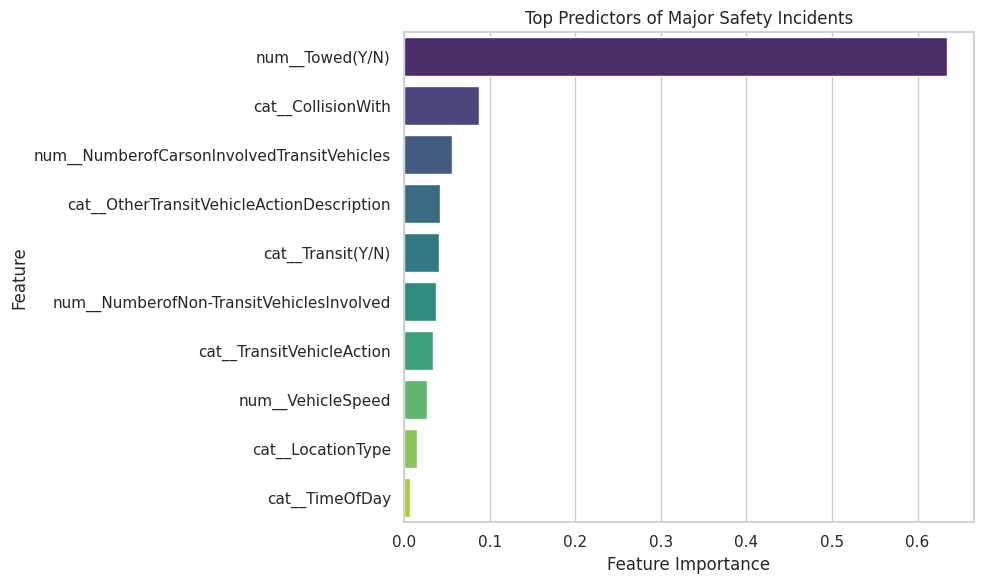

In [29]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model


rf_model = Pipeline_2.named_steps['classifier']

# Get feature names
ohe = Pipeline_2.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
#all_feature_names = list(num_cols) + list(encoded_cat_cols)
all_feature_names = Pipeline_2.named_steps['preprocessing'].get_feature_names_out()


# Get importances
importances = np.mean([
            tree.feature_importances_ for tree in rf_model.estimators_
        ], axis=0)


feat_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

# Get importances
#importances = rf_model.feature_importances_
#feat_importance_df = pd.DataFrame({
#    'Feature': all_feature_names,
#    'Importance': importances
#}).sort_values(by='Importance', ascending=False)


# Mapping only for categorical features
#original_feature_map = {encoded: original.split('_')[0] for encoded, original in zip(encoded_cat_cols, cat_cols)}
original_feature_map = {encoded: encoded.split('_')[0] for encoded in encoded_cat_cols}

# Aggregate importance by original feature
#feat_importance_df['Original Feature'] = feat_importance_df['Feature'].apply(
#    lambda x: original_feature_map[x] if x in original_feature_map else x
#)

feat_importance_df['Original Feature'] = feat_importance_df['Feature'].apply(
    lambda x: original_feature_map[x] if x in encoded_cat_cols else x
)


top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [32]:
# Define the parameter grid
param_grid_et = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]

}

# Initialize ExtraTreesClassifier
et = ExtraTreesClassifier()

# Initialize GridSearchCV
grid_search_et = GridSearchCV(estimator=et, param_grid=param_grid_et, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search_et.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters for ExtraTreesClassifier:", grid_search_et.best_params_)

# Best model
best_et_model = grid_search_et.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


ValueError: 
All the 162 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/arrays/categorical.py", line 591, in astype
    new_cats = new_cats.astype(dtype=dtype, copy=copy)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Bus'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py", line 360, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 973, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/generic.py", line 6643, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/internals/managers.py", line 430, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/internals/managers.py", line 363, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py", line 758, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype.py", line 237, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype.py", line 179, in astype_array
    values = values.astype(dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/arrays/categorical.py", line 602, in astype
    raise ValueError(msg)
ValueError: Cannot cast object dtype to float32


In [33]:
#checking for object type variables that conflict with extra tree classifiers

print(X_train.dtypes)
print(X_test.dtypes)
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols.tolist())

NTDID                                    category
PrimaryUZAUACECode                       category
Rail/Bus/Ferry                           category
ModeName                                 category
Mode                                     category
TOS                                      category
Year                                     category
EventType                                  object
EventTypeGroup                             object
CollisionWith                              object
Towed(Y/N)                                   bool
NumberofTransitVehiclesInvolved             int64
NumberofNon-TransitVehiclesInvolved         int64
NumberofCarsonInvolvedTransitVehicles       int64
LocationType                               object
Weather                                  category
Lighting                                 category
RoadConfiguration                        category
PathCondition                            category
RightofWayCondition                      category


In [35]:
Pipeline_3.fit(X_train, y_train)

# Predict on Test Set
y_pred = Pipeline_3.predict(X_test)
y_probs = Pipeline_3.predict_proba(X_test)[:, 1]  # Probabilities for class 1


print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.47      0.48      2834
           1       0.84      0.86      0.85      9597

    accuracy                           0.77     12431
   macro avg       0.67      0.66      0.67     12431
weighted avg       0.76      0.77      0.77     12431

Confusion Matrix:
[[1324 1510]
 [1370 8227]]
ROC-AUC Score: 0.8001984748968467



Top 10 Predictive Features:
                                 Feature  Importance
0                             Towed(Y/N)    0.342519
4                           VehicleSpeed    0.209993
13                               Weekday    0.125459
11  OtherTransitVehicleActionDescription    0.080195
9                           LocationType    0.055488
10                  TransitVehicleAction    0.048479
15                             TimeOfDay    0.042243
12                          Transit(Y/N)    0.032870
2    NumberofNon-TransitVehiclesInvolved    0.014884
8                          CollisionWith    0.014513


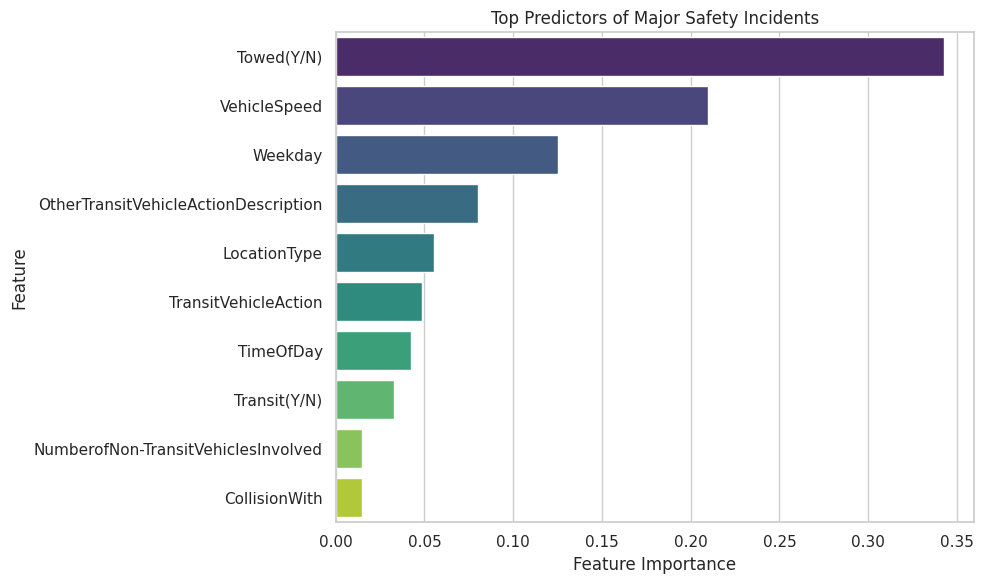

In [36]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_3.named_steps['classifier']

# Get feature names
ohe = Pipeline_3.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

# Get importances
importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top N features
top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
Pipeline_10.fit(X_train, y_train)
# Compute Permutation Importance
KNNresult = permutation_importance(Pipeline_10, X_test, y_test, n_repeats=1, random_state=42, scoring='accuracy')

In [ ]:
y_pred = Pipeline_10.predict(X_test)  # Binary class labels
y_probs = Pipeline_10.predict_proba(X_test)[:, 1]  # Probabilities

# Print Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))  # Use probabilities instead of labels

In [ ]:

ohe = Pipeline_10.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': KNNresult.importances_mean
}).sort_values(by='Importance', ascending=False)


# Display top N features
top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()